In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pydicom
from scipy.optimize import curve_fit


import math
from skimage import color
from skimage.io import imread
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
import skimage.draw as sdraw
from skimage.util import img_as_ubyte

from skimage.morphology import binary_closing, disk, erosion, dilation
import scipy.ndimage as nd
import skimage.draw as sdraw

from matplotlib import colors
from skimage.measure import label, regionprops

In [15]:
# #6ms 20FA
# DICOM1 = 'NPERIODIC_140423_1.MR.0003.0001.2023.04.14.15.23.33.996403.63216740.IMA'
# DICOM2 = 'NPERIODIC_140423_1.MR.0003.0002.2023.04.14.15.23.33.996403.63216758.IMA'
# DICOM3 = 'NPERIODIC_140423_1.MR.0003.0003.2023.04.14.15.23.33.996403.63216776.IMA'
# DICOM4 = 'NPERIODIC_140423_1.MR.0003.0004.2023.04.14.15.23.33.996403.63216794.IMA'
# DICOM5 = 'NPERIODIC_140423_1.MR.0003.0005.2023.04.14.15.23.33.996403.63216812.IMA'
# DICOM6 = 'NPERIODIC_140423_1.MR.0003.0006.2023.04.14.15.23.33.996403.63216830.IMA'
# DICOM7 = 'NPERIODIC_140423_1.MR.0003.0007.2023.04.14.15.23.33.996403.63216848.IMA'
# DICOM8 = 'NPERIODIC_140423_1.MR.0003.0008.2023.04.14.15.23.33.996403.63216866.IMA'
# DICOM9 = 'NPERIODIC_140423_1.MR.0003.0009.2023.04.14.15.23.33.996403.63216884.IMA'
# DICOM10 = 'NPERIODIC_140423_1.MR.0003.0010.2023.04.14.15.23.33.996403.63216902.IMA'
# DICOM11 = 'NPERIODIC_140423_1.MR.0003.0011.2023.04.14.15.23.33.996403.63216920.IMA'
# DICOM12 = 'NPERIODIC_140423_1.MR.0003.0012.2023.04.14.15.23.33.996403.63216938.IMA'
# DICOMFILENAME = [DICOM1,DICOM2,DICOM3,DICOM4,DICOM5,DICOM6,DICOM7,DICOM8,DICOM9,DICOM10,DICOM11,DICOM12]

In [49]:
fa = 10
tr = 6
TR = tr*1e-3
TE = TR/2 
N = 5

DICOMFILENAME = []
for i in range (0,N):
    DICOM1 = 'recon/n_periodic/tr'+str(tr)+'_n'+str(N)+'_echo'+str(i+1)+'.dcm'

    DICOMFILENAME.append(DICOM1)
    print(DICOM1)

recon/n_periodic/tr6_n5_echo1.dcm
recon/n_periodic/tr6_n5_echo2.dcm
recon/n_periodic/tr6_n5_echo3.dcm
recon/n_periodic/tr6_n5_echo4.dcm
recon/n_periodic/tr6_n5_echo5.dcm


In [50]:
#LOAD DICOM DATA
NPeriod_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
TIME = np.asarray([], dtype = float)
for i in range (0,N):
    filepath = DICOMFILENAME[i]
    img = pydicom.read_file(filepath)
    NPeriod_DATA = np.append(NPeriod_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
    #Corresponding "time" on exponential fit for each array layer
    TIME = np.append(TIME, TE + TR*i)
NPeriod_DATA =  np.delete(NPeriod_DATA,0,0)
#pixel array for different TR stored in NPeriod_DATA



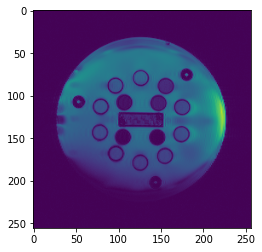

In [58]:
from IPython.display import clear_output
for i in range (0,N):
    plt.imshow(NPeriod_DATA[i,:,:])
    plt.show()
    clear_output(wait=True)
plt.show()
# image = GOLDSTD_DATA[0,:,:]
# hist, bin_edges = np.histogram(image)
# barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.
# plt.bar(bin_edges[:-1], hist, width=barw, align='edge') 


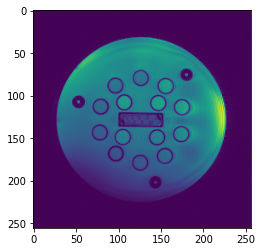

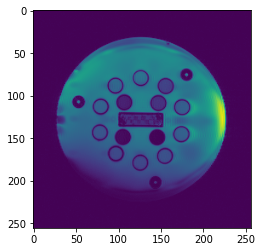

In [60]:
plt.figure(1)
plt.imshow(NPeriod_DATA[0,:,:])
plt.figure(2)
plt.imshow(NPeriod_DATA[3,:,:])

<BarContainer object of 10 artists>

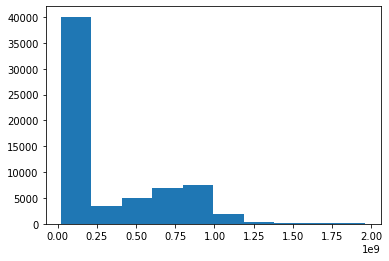

In [37]:
image = NPeriod_DATA[2,:,:]
hist, bin_edges = np.histogram(image)
barw = bin_edges[1]-bin_edges[0] # Should be the same for all bins.
plt.bar(bin_edges[:-1], hist, width=barw, align='edge') 


### USE STANDARD MASK

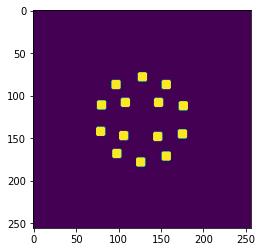

In [69]:
STANDARD_MASK_LABEL = np.load("Figure/MASKLABEL_2.npy")
STANDARD_MASK = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if(STANDARD_MASK_LABEL[i,j]>0):
            STANDARD_MASK[i,j]= 1
            

plt.imshow(STANDARD_MASK)

### Fitting to calculate R2* of the phantom

In [70]:
#R2* Fitting
def func(t, A, R2Star):
    return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
R2StarImage = np.asarray([], dtype = float)
for x in range (0,256):
    for y in range (0,256):
        popt, pcov = curve_fit(func, TIME, NPeriod_DATA[:,x,y]*STANDARD_MASK[x,y])
        PixelR2Star = popt[1]
        R2StarImage = np.append(R2StarImage, PixelR2Star)
R2StarImage = R2StarImage.reshape(256,256)


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


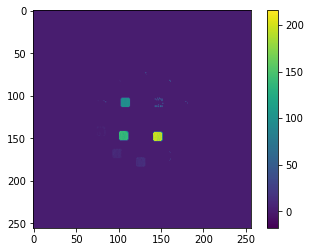

In [71]:
plt.imshow(R2StarImage)
plt.colorbar()

### T2* and Mean T2* value, Standard Deviation of T2* value in each circle

0.9583371595917844
0.202262675910586
0.9849069572054738
0.11450398217221264
0.9831828765891375
0.12752217130663157
0.0104097114433655
0.0003211283753947253
0.8312583941228563
0.3716148692819009
0.9436099839705882
0.22404862983913185
0.9716070518168836
0.15641856816532676
0.798090660004902
0.35250998824244145
1.0
0.0
0.007411836155426819
0.0007033004567807032
0.005205489312259563
0.0002094557509574367
0.1164110151350525
0.10051389648108251
0.9598060758015623
0.19024042604049934
0.08471667378047
0.017783103064702335


Text(0.5, 1.0, 'T2* value map (ms)')

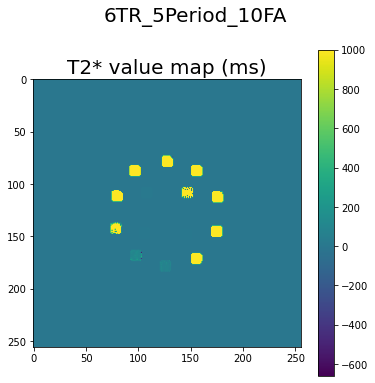

In [75]:
T2SMAP = np.zeros((256,256))
#Label the mask
LABELMASK = STANDARD_MASK_LABEL
MEAN = np.asarray([], dtype = float)
SD = np.asarray([], dtype = float)
for number in range (1,15):
    T2StarMeasured = np.asarray([], dtype = float)
    
    #Generate mask of one circle
    CircleMASK = np.zeros((256,256))
    for i in range (0,256):
        for j in range (0,256):
            if(LABELMASK[i,j]==number):
                CircleMASK[i,j] = 1

    #Only the R2* values of that circle remain
    R2MAP1 = R2StarImage*CircleMASK

    for i in range (0,256):
        for j in range (0,256):
            if(R2MAP1[i,j] != 0 ): #and 1/R2MAP1[i,j] > (mean - 2 * sd) and 1/R2MAP1[i,j] < (mean + 2 * sd)
                T2StarMeasured = np.append(T2StarMeasured, 1/R2MAP1[i,j])
                #store T2*value in the T2* Map
                T2SMAP[i,j] = 1/R2MAP1[i,j]*1000 #ms
    final_list = [x for x in T2StarMeasured if (x > np.mean(T2StarMeasured) - 2 * np.std(T2StarMeasured))]
    final_list = [x for x in final_list if (x < np.mean(T2StarMeasured) + 2 * np.std(T2StarMeasured))]
    print(np.mean(T2StarMeasured))
    print(np.std(T2StarMeasured))
    MEAN = np.append(MEAN, np.mean(final_list))
    SD = np.append(SD, np.std(final_list))

plt.figure(figsize = (6,6))
plt.imshow(T2SMAP)
plt.colorbar()

plt.suptitle(str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA", fontsize = 20)
plt.title("T2* value map (ms)", fontsize = 20)

# plt.savefig("MASK_2RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA_T2StarMAP.jpg")
# np.save("MASK_2RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA_T2StarMAP.npy", T2SMAP)
# DATA = [MEAN, SD]
# np.save("MASK_2RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA_MEAN_STD.npy", DATA)


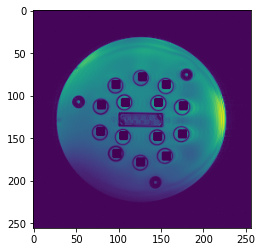

In [68]:
plt.imshow(NPeriod_DATA[0,:,:]*(np.ones(np.shape(STANDARD_MASK))-STANDARD_MASK))

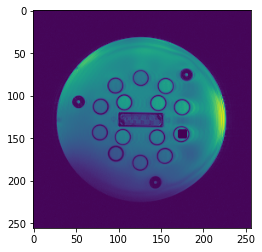

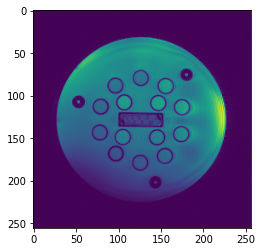

In [65]:
MASK_parts = np.zeros((256,256))
for i in range (0,256):
    for j in range (0,256):
        if (STANDARD_MASK_LABEL[i,j]!=9):
            MASK_parts[i,j]=1
plt.figure(1)
plt.imshow(NPeriod_DATA[0,:,:]*MASK_parts)
plt.figure(2)
plt.imshow(NPeriod_DATA[0,:,:])

5
recon/n_periodic/tr6_n5_echo1.dcm
recon/n_periodic/tr6_n5_echo2.dcm
recon/n_periodic/tr6_n5_echo3.dcm
recon/n_periodic/tr6_n5_echo4.dcm
recon/n_periodic/tr6_n5_echo5.dcm


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.11940077291605278
0.12189714950506442
0.11705699652021608
0.027219886856277534
0.016198280464543503
0.0005345948579979481
0.010422082496149798
0.0002942747825344146
0.012861605618709998
0.0003646874384624497
0.07636222131008875
0.044378525006685605
0.1695062656438433
0.222515843071237
0.17993734804772848
0.09552911402932493


C:\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Python\Python310\lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Python\Python310\lib\site-packages\numpy\core\_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Python\Python310\lib\site-packages\numpy\core\_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
C:\Python\Python310\lib\site-packages\numpy\core\_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan
nan
0.007325183378297342
0.0002528718923999249
0.005200714855224083
0.00018423120503416462
0.11965666860200314
0.030629450549570746
0.059462173756558025
0.008469030682908692
0.08138977531381693
0.012052301942338316
6
recon/n_periodic/tr6_n6_echo1.dcm
recon/n_periodic/tr6_n6_echo2.dcm
recon/n_periodic/tr6_n6_echo3.dcm
recon/n_periodic/tr6_n6_echo4.dcm
recon/n_periodic/tr6_n6_echo5.dcm
recon/n_periodic/tr6_n6_echo6.dcm


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.09781864299661708
0.01954523558379636
0.07083553400633184
0.00976935954862109
0.02127566526326974
0.002338864934938798
0.010658415947105768
0.0003547135642420555
0.015641708968281976
0.00047492402408387795
0.09757184237347362
0.020748701799213398
0.028742695710026793
0.002169534353944902
0.11535908841059143
0.031088444622689768
0.041140659153392975
0.0025237324426463275
0.007507779533084697
0.0002625716411383871
0.005258764127372778
0.00015295806086783177
0.1509607910269509
0.07331935338396854
0.05285766976000698
0.008123901900290558
0.1033200033680707
0.034984621214369675
7
recon/n_periodic/tr6_n7_echo1.dcm
recon/n_periodic/tr6_n7_echo2.dcm
recon/n_periodic/tr6_n7_echo3.dcm
recon/n_periodic/tr6_n7_echo4.dcm
recon/n_periodic/tr6_n7_echo5.dcm
recon/n_periodic/tr6_n7_echo6.dcm
recon/n_periodic/tr6_n7_echo7.dcm


C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.08596280558822575
0.04124946961699706
0.0776495175646185
0.014184170241660788
0.017337272598300212
0.0007712893472980441
0.010403196117606104
0.0002545806039299537
0.013815193936835961
0.00029485340580223223
0.11302211364556884
0.02768186583121236
0.02819741617641724
0.0017108015399502792
0.15809541692446866
0.05318830087339537
0.040811871454368875
0.0028833110731372583
0.007328463029348317
0.00022137040380854474
0.005113710932821228
0.0001880967768820958
0.11472664495269691
0.026490834414176094
0.0554431329555153
0.005770326110216801
0.08044564634269351
0.012393272561175964
12
recon/n_periodic/tr6_n12_echo1.dcm
recon/n_periodic/tr6_n12_echo2.dcm
recon/n_periodic/tr6_n12_echo3.dcm
recon/n_periodic/tr6_n12_echo4.dcm
recon/n_periodic/tr6_n12_echo5.dcm
recon/n_periodic/tr6_n12_echo6.dcm
recon/n_periodic/tr6_n12_echo7.dcm
recon/n_periodic/tr6_n12_echo8.dcm
recon/n_periodic/tr6_n12_echo9.dcm
recon/n_periodic/tr6_n12_echo10.dcm
recon/n_periodic/tr6_n12_echo11.dcm
recon/n_periodic/tr6_n12_e

C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:486: RuntimeWarning: overflow encountered in matmul
  cov_x = invR @ invR.T
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:900: RuntimeWarning: invalid value encountered in multiply
  pcov = pcov * s_sq
C:\Python\Python310\lib\site-packages\scipy\optimize\_minpack_py.py:906: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


0.14076994608649568
0.03517627174101729
0.062360935217825895
0.010438162607128737
0.01804292216597662
0.0007903554289479657
0.010774559677097492
0.0002912471912229156
0.014273842988566349
0.00034727922862587163
0.10493459259436863
0.014172907485866937
0.028164953842038938
0.0016138516302540604
0.09665972404555416
0.013414083634349486
0.03983470464290173
0.0013393118547732588
0.007485277255743707
0.00023552236953479488
0.00535338745151309
0.00021681575583471955
0.0829993304796337
0.009222388343475581
0.05377727694351656
0.0067679523221991856
0.07042896583863854
0.0071076071215730365


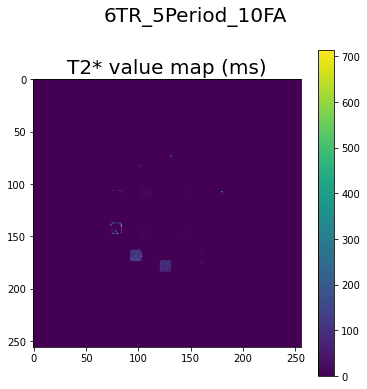

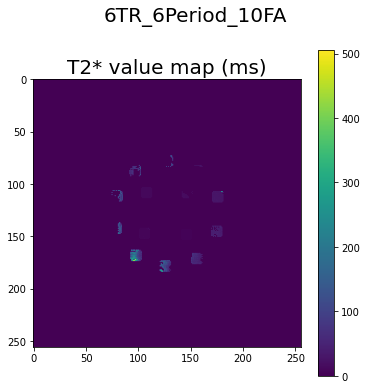

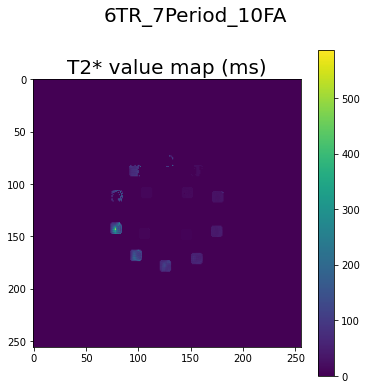

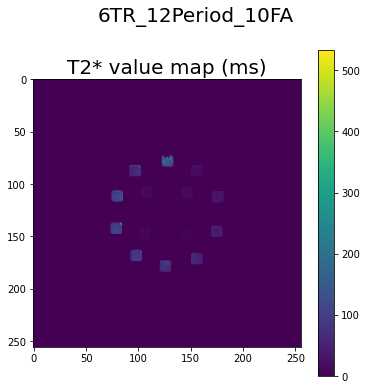

In [14]:
fa = 10
tr = 6
TR = tr*1e-3
TE = TR/2 
Period = [5,6,7,12]

for N in Period:
    print(N)
    DICOMFILENAME = []
    for i in range (0,N):
        DICOM1 = 'recon/n_periodic/tr'+str(tr)+'_n'+str(N)+'_echo'+str(i+1)+'.dcm'

        DICOMFILENAME.append(DICOM1)
        print(DICOM1)

    #LOAD DICOM DATA
    NPeriod_DATA = np.asarray(np.zeros((1,256,256)), dtype = float)
    TIME = np.asarray([], dtype = float)
    for i in range (0,N):
        filepath = DICOMFILENAME[i]
        img = pydicom.read_file(filepath)
        NPeriod_DATA = np.append(NPeriod_DATA, img.pixel_array.reshape((1,256,256)), axis = 0)
        #Corresponding "time" on exponential fit for each array layer
        TIME = np.append(TIME, TE + TR*i)
    NPeriod_DATA =  np.delete(NPeriod_DATA,0,0)
    #pixel array for different TR stored in NPeriod_DATA

    STANDARD_MASK_LABEL = np.load("Figure/MASKLABEL_2.npy")
    STANDARD_MASK = np.zeros((256,256))
    for i in range (0,256):
        for j in range (0,256):
            if(STANDARD_MASK_LABEL[i,j]>0):
                STANDARD_MASK[i,j]= 1

    #R2* Fitting
    def func(t, A, R2Star):
        return A * np.exp(-R2Star * t)
            #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
    R2StarImage = np.asarray([], dtype = float)
    for x in range (0,256):
        for y in range (0,256):
            popt, pcov = curve_fit(func, TIME, NPeriod_DATA[:,x,y]*STANDARD_MASK[x,y])
            PixelR2Star = popt[1]
            R2StarImage = np.append(R2StarImage, PixelR2Star)
    R2StarImage = R2StarImage.reshape(256,256)

    T2SMAP = np.zeros((256,256))
    #Label the mask
    LABELMASK = STANDARD_MASK_LABEL
    MEAN = np.asarray([], dtype = float)
    SD = np.asarray([], dtype = float)
    for number in range (1,15):
        T2StarMeasured = np.asarray([], dtype = float)

        #Generate mask of one circle
        CircleMASK = np.zeros((256,256))
        for i in range (0,256):
            for j in range (0,256):
                if(LABELMASK[i,j]==number):
                    CircleMASK[i,j] = 1

        #Only the R2* values of that circle remain
        R2MAP1 = R2StarImage*CircleMASK

        for i in range (0,256):
            for j in range (0,256):
                if(R2MAP1[i,j] > 1 ): #and 1/R2MAP1[i,j] > (mean - 2 * sd) and 1/R2MAP1[i,j] < (mean + 2 * sd)
                    T2StarMeasured = np.append(T2StarMeasured, 1/R2MAP1[i,j])
                    #store T2*value in the T2* Map
                    T2SMAP[i,j] = 1/R2MAP1[i,j]*1000 #ms
        final_list = [x for x in T2StarMeasured if (x > np.mean(T2StarMeasured) - 2 * np.std(T2StarMeasured))]
        final_list = [x for x in final_list if (x < np.mean(T2StarMeasured) + 2 * np.std(T2StarMeasured))]
        print(np.mean(final_list))
        print(np.std(final_list))
        MEAN = np.append(MEAN, np.mean(final_list))
        SD = np.append(SD, np.std(final_list))

    plt.figure(figsize = (6,6))
    plt.imshow(T2SMAP)
    plt.colorbar()

    plt.suptitle(str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA", fontsize = 20)
    plt.title("T2* value map (ms)", fontsize = 20)

    plt.savefig("MASK_2RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA_T2StarMAP.jpg")
    np.save("MASK_2RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA_T2StarMAP.npy", T2SMAP)
    DATA = [MEAN, SD]
    np.save("MASK_2RESULT/NPeriodicT2Star/"+str(tr)+"TR_"+str(N)+"Period_"+str(fa)+"FA_MEAN_STD.npy", DATA)
